In [1]:
# Use "Base" Kernel for this notebook

#### Load a Dataset

In [2]:
# Perform imports and load the dataset:
import numpy as np
import pandas as pd

df = pd.read_csv('(A) Data/(A) PreProcessed_News Content Title_3000 Data.csv', usecols=['Detokenized', 'Labelling'], engine='python')
df.head()

,Labelling,Detokenized
0,1.0,olahraga pilates populer deret manfaat
1,1.0,janice tjen lolos nomor final chennai open
2,-1.0,pasu rsf duga bantai ribu warga sipil sudan
3,1.0,pertamina peduli salur bantu korban bencana su...
4,-1.0,cuaca panas hujan banjir rob bayang wilayah


In [3]:
df.isnull().sum()

Labelling      2
Detokenized    2
dtype: int64

In [4]:
df = df.dropna()

In [5]:
df.isnull().sum()

Labelling      0
Detokenized    0
dtype: int64

In [6]:
df.shape

(2791, 2)

#### Take a Quick Look at the Label

In [7]:
df['Labelling'].value_counts()

Labelling
 0.0    1331
-1.0    1026
 1.0     434
Name: count, dtype: int64

<BarContainer object of 3 artists>

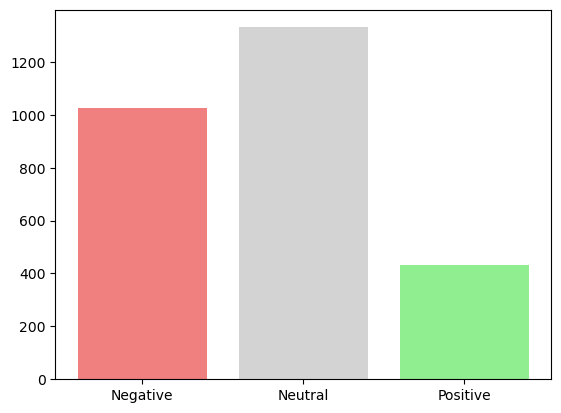

In [11]:
import matplotlib.pyplot as plt
plt.bar(df['Labelling'].value_counts().index, df['Labelling'].value_counts())
labels = df['Labelling'].value_counts().index
counts = df['Labelling'].value_counts().values
color_map = {-1.0: 'lightcoral', 0.0: 'lightgray', 1.0: 'lightgreen'}
colors = [color_map[label] for label in labels]
plt.xticks([-1.0, 0.0, 1.0], ['Negative', 'Neutral', 'Positive']) 
plt.bar(labels, counts, color=colors)

#### Split the Data into Training and Testing sets

##### 80 20

In [8]:
from sklearn.model_selection import train_test_split

X = df['Detokenized']  

# Map labels to 0, 1, 2
label_mapping = {-1: 0, 0: 1, 1: 2}
y = df['Labelling'].map(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(y.value_counts()) 

Labelling
1    1331
0    1026
2     434
Name: count, dtype: int64


#### Scikit-learn's CountVectorizer
Text preprocessing, tokenizing and the ability to filter out stopwords are all included in [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which builds a dictionary of features and transforms documents to feature vectors.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

# Only the X_train not the whole X
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(2232, 5520)

#### Transform Counts to Frequencies with Tf-idf
While counting words is helpful, longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid this we can simply divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called **tf** for Term Frequencies.

Another refinement on top of **tf** is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called **tf–idf** for “Term Frequency times Inverse Document Frequency”.

Both tf and tf–idf can be computed as follows using [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html):

==  
Because the term "the" is so common, term frequency will tend to incorrectly emphasize documents which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms "red" and "dogs". 
    
An inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.  
== ( See "NLP With Python Notebook") 

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2232, 5520)

Note: the `fit_transform()` method actually performs two operations: it fits an estimator to the data and then transforms our count-matrix to a tf-idf representation.

In [12]:
X_train_tfidf

<2232x5520 sparse matrix of type '<class 'numpy.float64'>'
	with 27823 stored elements in Compressed Sparse Row format>

#### Combine Steps with TfidVectorizer
In the future, we can combine the CountVectorizer and TfidTransformer steps into one using [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_train_tfidf.shape

(2232, 5520)

In [14]:
X_test_tfidf = vectorizer.transform(X_test) # remember to use the original X_train set
X_test_tfidf.shape

(559, 5520)

#### CNN Classifier

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [16]:
# Convert the sparse matrix to a dense numpy array
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

In [18]:
model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(3, activation = 'softmax')    # < softmax activation here
    ]
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X_train_tfidf_dense,
    y_train,
    epochs=20
)

Epoch 1/20
70/70 [==============================] - 1s 2ms/step - loss: 1.0420
Epoch 2/20
70/70 [==============================] - 0s 2ms/step - loss: 0.8606
Epoch 3/20
70/70 [==============================] - 0s 2ms/step - loss: 0.5922
Epoch 4/20
70/70 [==============================] - 0s 2ms/step - loss: 0.3719
Epoch 5/20
70/70 [==============================] - 0s 2ms/step - loss: 0.2294
Epoch 6/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1497
Epoch 7/20
70/70 [==============================] - 0s 2ms/step - loss: 0.1018
Epoch 8/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0769
Epoch 9/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0634
Epoch 10/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0537
Epoch 11/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0472
Epoch 12/20
70/70 [==============================] - 0s 2ms/step - loss: 0.0434
Epoch 13/20
70/70 [==============================

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                138025    
                                                                 
 dense_4 (Dense)             (None, 15)                390       
                                                                 
 dense_5 (Dense)             (None, 3)                 48        
                                                                 
Total params: 138,463
Trainable params: 138,463
Non-trainable params: 0
_________________________________________________________________


In [20]:
predictions = model.predict(X_test_tfidf_dense)

18/18 [==============================] - 0s 1ms/step


In [21]:
# 2. Convert probabilities to class labels (0, 1, or 2)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

[1 1 0 1 0 2 1 1 0 0 0 2 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 2 0 1 0 1 0 0 2
 0 0 1 0 1 0 1 0 2 0 0 1 1 1 2 0 1 2 0 0 0 1 1 1 0 1 2 1 1 1 0 2 0 1 1 0 0
 1 0 1 1 1 2 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 2 1 1 0 1 1 1 0 1 2 1 1
 1 2 0 0 0 0 1 0 0 1 0 1 1 1 2 2 1 0 0 1 1 2 0 1 0 1 2 0 0 0 1 0 2 1 0 0 0
 1 0 0 2 0 0 1 1 1 0 2 0 0 1 1 1 1 1 1 1 2 1 1 1 2 0 1 0 1 0 1 1 2 1 2 0 0
 0 1 2 1 1 1 1 1 1 1 1 2 2 2 1 0 1 1 0 0 1 1 1 1 1 1 0 2 2 0 1 1 1 1 0 1 1
 1 0 1 0 1 2 2 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 2 2 1 1 1 1 1 1
 1 2 0 0 0 0 1 1 2 1 0 0 1 1 1 0 0 2 1 0 0 0 1 0 2 0 0 0 2 1 1 0 2 1 1 2 1
 2 2 1 1 1 1 1 0 1 0 1 1 2 2 2 1 1 0 1 2 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0
 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 2 0 0 2 1 1 2 0 2 1 1 2 1 0 0 1 1 0 0 2 2
 1 0 0 1 2 1 1 0 0 1 1 1 0 1 2 0 0 2 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 2 1
 1 1 1 0 1 1 0 2 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0 2 1 1 1 1 2 2 1 2 1
 0 0 1 1 1 0 2 0 1 0 1 1 0 1 1 0 1 0 2 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 2
 2 0 1 1 1 0 0 1 1 1 1 1 

#### Evaluating Model Performance

In [22]:
from sklearn.metrics import confusion_matrix,classification_report

In [23]:
y_pred_classes = predictions.argmax(axis=1)
confusion_matrix(y_test, y_pred_classes)

array([[140,  56,   8],
       [ 46, 201,  26],
       [  8,  31,  43]], dtype=int64)

In [24]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.72      0.69      0.70       204
           1       0.70      0.74      0.72       273
           2       0.56      0.52      0.54        82

    accuracy                           0.69       559
   macro avg       0.66      0.65      0.65       559
weighted avg       0.69      0.69      0.69       559

